# How to rediscover the Higgs boson yourself!

This notebook is to get a felling of how to do a real analysis. ATLAS Open Data http://opendata.atlas.cern has been used to rediscover the Higgs boson yourself!

The datasets used in this notebook have already been filtered to include at least 2 photons per event, so that processing is quicker.

This analysis loosely follows the discovery of the Higgs boson by ATLAS https://arxiv.org/pdf/1207.7214.pdf (mostly Section 5 and 5.1)

Feynman diagrams can be found at https://www.particlezoo.net

#### source, the main notebook can be found at  
https://github.com/meevans1/how-to-rediscover-the-higgs-with-photons/blob/master/Higgs%20photon%20analysis.ipynb

#### I edited it to be somehow simpiler and make sure the codes are compatible with the newer version of uproot (uproot4).




<CENTER><img src="images/Hyy_feynman.png" style="width:40%"></CENTER>


## First time setup on your computer (no need on mybinder)

This first cell only needs to be run the first time you open this notebook on your computer.

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on binder, you don't need to run this cell.


In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib lmfit --user # install required packages

## To setup everytime

Cell -> Run All Below

to be done every time you re-open this notebook


In [51]:
import uproot  # for reading .root files
import pandas as pd  # to store data as dataframe
import time  # to measure time to analyse
import math  # for mathematical functions such as square root
import numpy as np  # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt  # for plotting
from lmfit.models import (
    PolynomialModel,
    GaussianModel,
)  # for the signal and background fits
from matplotlib.ticker import MaxNLocator, AutoMinorLocator  # for minor ticks

<a id='fraction'></a>


General definitions of luminosity, fraction of data used, where to access the input files


In [52]:
lumi = 0.5  # fb-1 # data_A only
# lumi = 1.9 # fb-1 # data_B only
# lumi = 2.9 # fb-1 # data_C only
# lumi = 4.7 # fb-1 # data_D only
# lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1  # 0.8  # reduce this is you want the code to run quicker

<a id='samples'></a>


Samples to process.


In [464]:
# For using Data_A, Data_B, Data_C and Data_D you can use the following path:
# tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/" # web address

# get the tree from the root file using uproot
# data = uproot.open(
#     # "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root",
#     "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root",
#     # "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root",
#     # "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root",
# )["mini"]

#import uproot

#file_paths = [
#    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root",
    #    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root",
    #    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root",
    #    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root",
# ]

# create a list of trees #! if you want to use all the data, uncomment the upper part and comment this part
#data = [uproot.open(file_path)["mini"] for file_path in file_paths]
#concatenated_file = uproot.concatenate(data)



In [54]:
#get the tree from the root file using uproot, A is used for that test
data = uproot.open("Input/GamGam/Data/data_A.GamGam.root")["mini"]

In [468]:
data[0].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
eventNumber          | int32_t                  | AsDtype('>i4')
channelNumber        | int32_t                  | AsDtype('>i4')
mcWeight             | float                    | AsDtype('>f4')
scaleFactor_PILEUP   | float                    | AsDtype('>f4')
scaleFactor_ELE      | float                    | AsDtype('>f4')
scaleFactor_MUON     | float                    | AsDtype('>f4')
scaleFactor_PHOTON   | float                    | AsDtype('>f4')
scaleFactor_TAU      | float                    | AsDtype('>f4')
scaleFactor_BTAG     | float                    | AsDtype('>f4')
scaleFactor_LepTR... | float                    | AsDtype('>f4')
scaleFactor_Photo... | float                    | AsDtype('>f4')
trigE                | bool                     | AsDtype(

In [56]:
data_arrays = data.arrays()
data_arrays

<Array [{runNumber: 297730, ...}, ..., {...}] type='430344 * {runNumber: in...'>

In [57]:
type(data["photon_E"])  # uproot.models.TBranch.Model_TBranchMethods

uproot.models.TBranch.Model_TBranchElement_v10

In [58]:
print(type(data["photon_pt"]))  # uproot.models.TBranch.Model_TBranchElement_v10
print(type(data_arrays["photon_pt"]))  #! awkward.highlevel.Array
print(type(data_arrays))  #! array of awkward.highlevel.Array s

<class 'uproot.models.TBranch.Model_TBranchElement_v10'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>


In [461]:
# show first column of data
for i in range(0, 10):
    print(photon_pt[:, 0][i], ",", photon_pt[:, 1][i])

# photon_pt

46690.223 , 29442.607
60888.74 , 37795.01
39186.21 , 25327.361
35529.688 , 29579.598
48605.836 , 29717.975
64788.35 , 52240.426
101266.49 , 47761.832
57783.535 , 28445.018
39878.234 , 37740.383
48048.926 , 26051.443


In [ ]:
# get the photon arrays from the data_arrays
photon_pt = data_arrays["photon_pt"]
photon_eta = data_arrays["photon_eta"]
photon_phi = data_arrays["photon_phi"]
photon_E = data_arrays["photon_E"]
photon_isTightID = data_arrays["photon_isTightID"]
photon_etcone20 = data_arrays["photon_etcone20"]

Define function to calculate diphoton invariant mass


In [ ]:
def calc_myy(photon_pt, photon_eta, photon_phi, photon_E):
    # first photon is [0], 2nd photon is [1] etc
    # x-component of photon[0] momentum
    px_0 = photon_pt[:, 0] * np.cos(photon_phi[:, 0])
    # y-component of photon[0] momentum
    py_0 = photon_pt[:, 0] * np.sin(photon_phi[:, 0])
    # z-component of photon[0] momentum
    pz_0 = photon_pt[:, 0] * np.sinh(photon_eta[:, 0])
    # x-component of photon[1] momentum
    px_1 = photon_pt[:, 1] * np.cos(photon_phi[:, 1])
    # y-component of photon[1] momentum
    py_1 = photon_pt[:, 1] * np.sin(photon_phi[:, 1])
    # z-component of photon[1] momentum
    pz_1 = photon_pt[:, 1] * np.sinh(photon_eta[:, 1])
    sumpx = px_0 + px_1  # x-component of diphoton momentum
    sumpy = py_0 + py_1  # y-component of diphoton momentum
    sumpz = pz_0 + pz_1  # z-component of diphoton momentum
    sump = np.sqrt(
        sumpx**2 + sumpy**2 + sumpz**2
    )  # magnitude of diphoton momentum
    sumE = photon_E[:, 0] + photon_E[:, 1]  # energy of diphoton system
    return np.sqrt(sumE**2 - sump**2) / 1000  # /1000 to go from MeV to GeV

In [ ]:
myy = calc_myy(photon_pt, photon_eta, photon_phi, photon_E)
myy  # invariant mass of the photon pair (in GeV) for each event in the dataset without cuts or selections

<Array [170, 110, 79.6, 65.3, ..., 70.2, 14.6, 98.2] type='430344 * float32'>

(array([2794., 2591., 2767., 2756., 2760., 2700., 2616., 2606., 2552.,
        2498., 2464., 2523., 2414., 2424., 2402., 2288., 2325., 2327.,
        2289., 2317., 2256., 2200., 2177., 2156., 2031., 2120., 2032.,
        2095., 2015., 1968., 1853., 1962., 1890., 1794., 1756., 1879.,
        1784., 1738., 1775., 1735., 1719., 1731., 1736., 1635., 1699.,
        1608., 1577., 1566., 1559., 1540., 1570., 1463., 1521., 1574.,
        1446., 1453., 1400., 1397., 1457., 1388., 1298., 1310., 1292.,
        1341., 1310., 1310., 1175., 1206., 1117., 1269., 1171., 1105.,
        1134., 1136., 1144., 1140., 1118., 1104., 1079., 1138., 1030.,
        1034., 1036., 1068., 1032.,  971., 1025.,  990.,  920.,  999.,
         953.,  938.,  904.,  838.,  877.,  882.,  872.,  883.,  907.,
         866.,  827.,  835.,  805.,  829.,  834.,  762.,  810.,  774.,
         773.,  746.,  703.,  746.,  736.,  705.,  677.,  706.,  707.,
         656.,  707.,  709.]),
 array([ 90.        ,  90.58333588,  91.166664

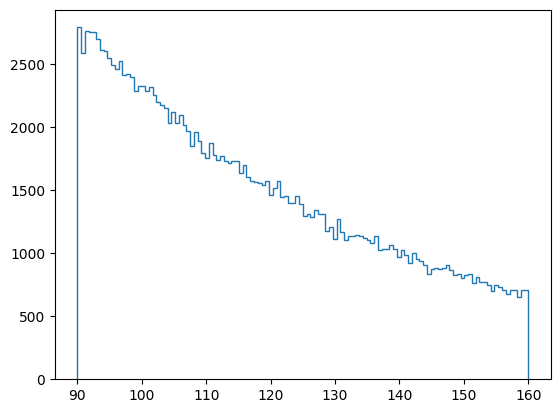

In [ ]:
myy = calc_myy(photon_pt, photon_eta, photon_phi, photon_E)
myy  # invariant mass of the photon pair (in GeV) for each event in the dataset without cuts or selections

plt.hist(myy, bins=120, range=(90, 160), histtype="step", label="Higgs")

## introducing cuts


If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "Applying a cut" cell.


In [ ]:
import numpy as np

# data_arrays= # arrays = events.arrays(["px1", "py1", "M"])
# pt1 = np.sqrt(arrays.px1**2 + arrays.py1**2)
photon_selected = data_arrays[
    (photon_pt[:, 0] > 45000)
    & (photon_pt[:, 1] > 35000)
    & (photon_isTightID[:, 0] == 1)
    & (photon_isTightID[:, 0] == 1)
    & (photon_etcone20[:, 0] < 3500)
    & (photon_etcone20[:, 1] < 3500)
    & ((abs(photon_eta[:, 0]) > 1.52) | (abs(photon_eta[:, 0]) < 1.37))
    & ((abs(photon_eta[:, 1]) > 1.52) | (abs(photon_eta[:, 1]) < 1.37))
]

In [ ]:
len(photon_selected)

23422

In [ ]:
photon_info= ["photon_pt", "photon_eta", "photon_phi", "photon_E"]


photon_pt_selected = photon_selected["photon_pt"]
photon_eta_selected = photon_selected["photon_eta"]
photon_phi_selected = photon_selected["photon_phi"]
photon_E_selected = photon_selected["photon_E"]

(array([72., 84., 91., 76., 71., 74., 72., 79., 67., 80., 78., 62., 67.,
        79., 85., 65., 73., 71., 74., 76., 61., 79., 85., 77., 74., 79.,
        65., 79., 52., 81., 58., 65., 54., 69., 59., 63., 60., 71., 60.,
        63., 66., 71., 64., 63., 53., 65., 63., 43., 63., 63., 47., 70.,
        69., 65., 73., 66., 65., 61., 54., 59., 55., 53., 67., 61., 55.,
        67., 57., 61., 58., 68., 57., 52., 50., 41., 64., 71., 57., 52.,
        54., 50., 57., 54., 47., 44., 46., 67., 56., 52., 56., 53., 47.,
        50., 41., 50., 52., 53., 78., 52., 43., 52., 51., 49., 47., 52.,
        55., 51., 44., 50., 57., 56., 47., 44., 56., 51., 50., 49., 41.,
        50., 39., 46., 36., 58., 44., 38., 48., 49., 43., 37., 54., 44.,
        47., 46., 34., 32., 34., 44., 49., 45., 51., 32., 42., 40., 40.,
        47., 38., 46., 42., 34., 35., 46., 31., 39., 31., 34., 33., 41.,
        34., 35., 41., 28., 30., 51., 35., 33., 28., 33., 29., 34., 48.,
        36., 27., 38., 34., 37., 35., 31., 35., 30.

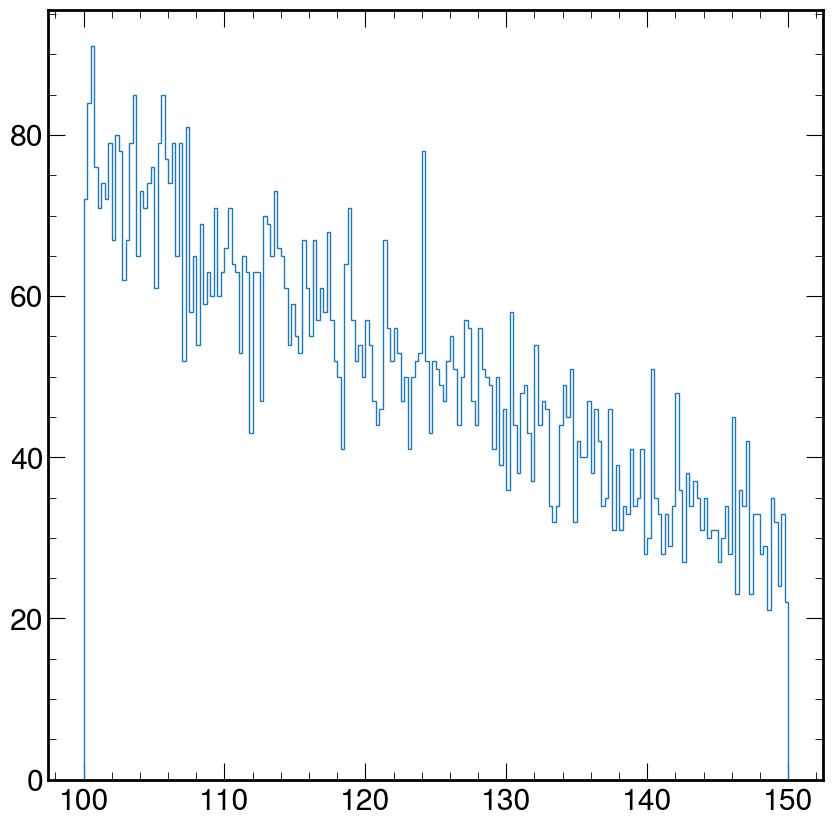

In [460]:
myy_selected = calc_myy(
    photon_pt_selected, photon_eta_selected, photon_phi_selected, photon_E_selected
)
myy_selected  # invariant mass of the photon pair (in GeV) for each event in the dataset without cuts or selections

plt.hist(myy_selected, bins=200, range=(100, 150), histtype="step", label="Higgs")

## plotting

In [457]:
xmin = 100  # GeV
xmax = 150  # GeV
step_size = 2  # GeV

bin_edges = np.arange(
    start=xmin,  # The interval includes this value
    stop=xmax + step_size,  # The interval doesn't include this value
    step=step_size,
)  # Spacing between values

bin_centres = np.arange(
    start=xmin + step_size / 2,  # The interval includes this value
    stop=xmax + step_size / 2,  # The interval doesn't include this value
    step=step_size,
)  # Spacing between values

In [458]:
def plot_data(myy_selected):
    # to have this function work, akward array needs to be converted to numpy array
    data_x, _ = np.histogram(myy_selected.to_numpy(), bins=bin_edges)

    data_x_errors = np.sqrt(data_x)  # statistical error on the data

    plt.errorbar(
        x=bin_centres, y=data_x, yerr=data_x_errors, label="Data", fmt="ko"
    )  # 'k' means black and 'o' means circles

    # data fit
    polynomial_mod = PolynomialModel(4)  # 4th order polynomial
    gaussian_mod = GaussianModel()  # Gaussian
    # set initial guesses for the parameters of the polynomial model
    pars = polynomial_mod.guess(
        data_x,  # data to use to guess parameter values
        x=bin_centres,
        c0=np.max(myy_selected),
        c1=0,
        c2=0,
        c3=0,
        c4=0,
    )
    # set initial guesses for the parameters of the Gaussian model
    pars += gaussian_mod.guess(
        data_x,  # data to use to guess parameter values
        x=bin_centres,
        amplitude=300,
        center=125.0,
        sigma=2.4,
    )
    model = polynomial_mod + gaussian_mod  # combined model
    out = model.fit(
        data_x,  # data to be fit
        pars,  # guesses for the parameters
        x=bin_centres,
        weights=1 / data_x_errors,
    )  # fit the model to the data

    # background part of fit
    params_dict = out.params.valuesdict()  # get the parameters from the fit to data
    c0 = params_dict["c0"]  # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c1 = params_dict["c1"]  # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c2 = params_dict["c2"]  # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c3 = params_dict["c3"]  # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c4 = params_dict["c4"]  # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    # get the background only part of the fit to data
    background = (
        c0
        + c1 * bin_centres
        + c2 * bin_centres**2
        + c3 * bin_centres**3
        + c4 * bin_centres**4
    )

    signal_x = data_x - background  # data fit - background fit = signal fit
    print(signal_x)
    # plot the signal + background fit
    plt.plot(
        bin_centres,  # x
        out.best_fit,  # y
        "-r",  # single red line
        label="Sig+Bkg Fit ($m_H=125$ GeV)",
    )
    # plot the background only fit
    plt.plot(
        bin_centres,  # x
        background,  # y
        "--r",  # dashed red line
        label="Bkg (4th order polynomial)",
    )

    plt.ylabel("Events")  # write y-axis label for main axes
    plt.ylim(200, 650)  # set the y axis limit for the main axes
    plt.xlabel(
        r"di-photon invariant mass $\mathrm{M_{\gamma\gamma}}$ [GeV]"
    )  # x-axis label

    # draw the legend
    plt.legend(frameon=False)  # no box around the legend

    print(f"chi^2 = {str(out.chisqr)}")
    print("gaussian centre = " + str(params_dict["center"]))
    print("gaussian sigma = " + str(params_dict["sigma"]))
    print("gaussian fwhm = " + str(params_dict["fwhm"]))

    return

[  1.44938328  -9.20774565  27.05621833   5.53876024 -28.48653685
 -20.7699918   24.9141746    0.76783961  16.96897857  -3.32833515
  -3.99393007  -9.92153668  26.9712126   21.74278343  14.42773952
   0.03674264  -3.44344738  21.95002738   1.15612288 -18.91010685
  -9.35750972  16.68116443 -10.95073618  23.56623473 -10.97237849]
chi^2 = 13.64444103483109
gaussian centre = 126.48582603067494
gaussian sigma = 1.69306549259051
gaussian fwhm = 3.9868644238530746


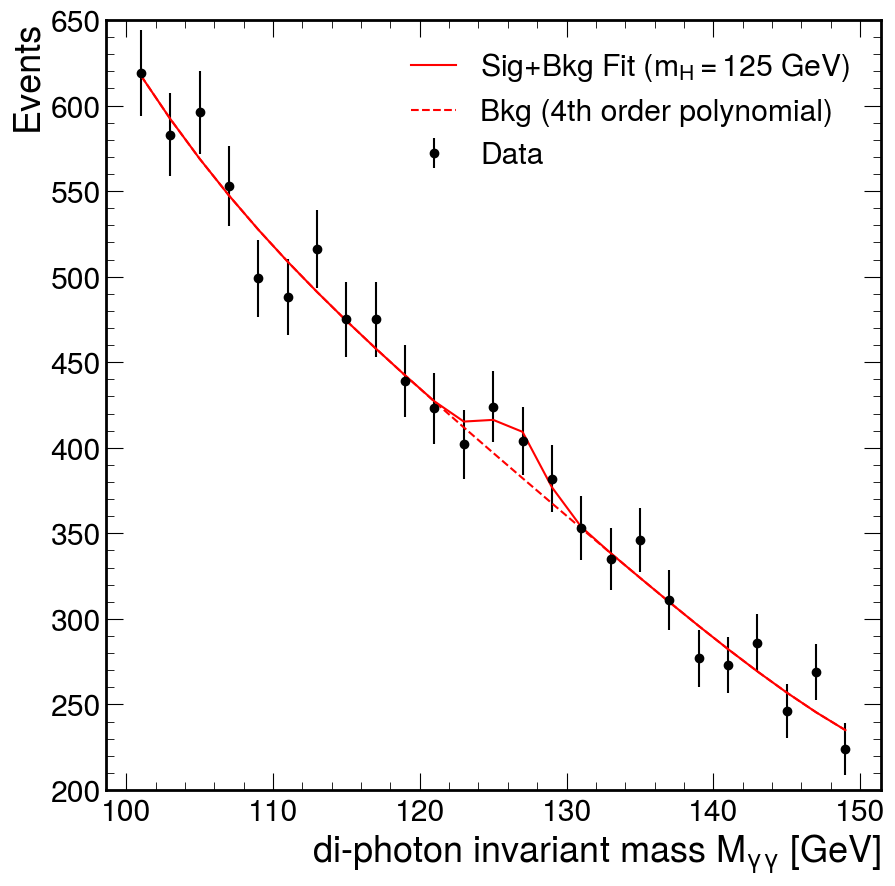

In [459]:
import mplhep as hep

hep.style.use("CMS")  # string aliases work too
plot_data(myy_selected)

#### What can you do to explore this analysis?
* increase the quantity of data, i.e. add data_B, data_C and data_D? 
* Try different initial guesses for the parameters of the fit in 'Plotting'?
* Try different functions for the fit in 'Plotting'?
* Check how many events are being thrown away by each cut in 'Applying a cut'?
* Add more cuts from the Higgs discovery paper in 'Changing a cut' and 'Applying a cut'?
* Add some extra commands in 'Plotting' to make it look more similar to the Higgs discovery paper?
* Your idea!
* You can download more data by on your pc and add them in the input/GamGam/Data, or use the links directly without downloading.

##### you can download them by clicking on the link
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root

https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root

https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root